In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()


from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
print(len(train_cands),len(dev_cands))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8272 888


In [4]:
# from util import load_external_labels

# %time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

# L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
# L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
# gold_labels_dev = [L[0,0] if L[0,0]==1 else -1 for L in L_gold_dev]
gold_labels_dev = [L[0,0] for L in L_gold_dev]


from snorkel.learning.utils import MentionScorer

Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

# gold_labels_dev = []
# for i,L in enumerate(L_gold_dev):
#     gold_labels_dev.append(L[0,0])
    
# gold_labels_test = []
# for i,L in enumerate(L_gold_test):
#     gold_labels_test.append(L[0,0])
    
# print(len(gold_labels_dev),len(gold_labels_test))
# print(gold_labels_dev.count(1),gold_labels_dev.count(-1))
# print(len(gold_labels_dev))

print(gold_labels_dev.count(1),gold_labels_dev.count(0))
print(len(gold_labels_dev))

296 592
888


In [34]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../../../snorkel/tutorials/glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [6]:
import bz2
from six.moves.cPickle import load

with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = load(ctd_f)

In [64]:
##### Discrete #########

def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0


def LF_in_ctd_unspecified(c):
    if(cand_in_ctd_unspecified(c)==1):
        return (-1,1)
    else:
        return (0,0)

def LF_in_ctd_therapy(c):
    if(cand_in_ctd_therapy(c)==1):
        return (-1,1)
    else:
        return (0,0)

def LF_in_ctd_marker(c):
    if(cand_in_ctd_marker(c)==1):
        return (1,1)
    else:
        return (0,0)

import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return (1,1) if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)==1):
        return (1,1)
    return (0,0)

def LF_d_induced_by_c_tight(c):
    if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)==1):
        return (1,1)
    return (0,0)

def LF_induce_name(c):
    return (1,1) if 'induc' in c.chemical.get_span().lower() else (0,0)     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return (1,1) if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else (0,0)

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_c_treat_d(c):
    if (rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_treat_d(c):
    if (rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_c_treat_d_wide(c):
    if (rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_c_d(c):
    return (1,1) if ('{{A}} {{B}}' in get_tagged_text(c)) else (0,0)

def LF_c_induced_d(c):
    return (1,1) if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else (0,0)

def LF_improve_before_disease(c):
    if(rule_regex_search_before_B(c, 'improv.*', -1)==-1):
        return (-1,1)
    return (0,0)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return (-1,1) if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    if (rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_induced_other(c):
    if (rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)==-1):
        return (-1,1)
    return (0,0)  

def LF_far_c_d(c):
    if (rule_regex_search_btw_AB(c, '.{100,5000}', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_far_d_c(c):
    if (rule_regex_search_btw_BA(c, '.{100,5000}', -1)==-1):
        return (-1,1)
    return (0,0)

def LF_risk_d(c):
    if (rule_regex_search_before_B(c, 'risk of ', 1)==1):
        return (1,1)
    return (0,0)

def LF_develop_d_following_c(c):
    return (1,1) if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return (1,1) if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else (0,0)

def LF_measure(c):
    return (-1,1) if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)

def LF_level(c):
    return (-1,1) if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else (0,0)

def LF_neg_d(c):
    return (-1,1) if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return (-1,1) if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else (0,0)


def LF_ctd_marker_c_d(c):
    l,s = LF_c_d(c)
    cl = cand_in_ctd_marker(c)
    return (l*cl,s*cl)

def LF_ctd_marker_induce(c):
    l1,s1 = LF_c_induced_d(c)
    l2,s2 = LF_d_induced_by_c_tight(c)
    cl = cand_in_ctd_marker(c)
    return ((l1 or l2)*cl,max(s1,s2)*cl)

def LF_ctd_therapy_treat(c):
    l,s = LF_c_treat_d_wide(c)
    cl = cand_in_ctd_therapy(c)
    return (l*cl,s*cl)

def LF_ctd_unspecified_treat(c):
    l,s = LF_c_treat_d_wide(c)
    cl = cand_in_ctd_unspecified(c)
    return (l*cl,s*cl)

def LF_ctd_unspecified_induce(c):
    l1,s1 = LF_c_induced_d(c)
    l2,s2 = LF_d_induced_by_c_tight(c)
    cl = cand_in_ctd_unspecified(c)
    return ((l1 or l2)*cl,max(s1,s2)*cl)


# def LF_ctd_marker_c_d(c):
#     return LF_c_d(c) * cand_in_ctd_marker(c)

# def LF_ctd_marker_induce(c):
#     return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

# def LF_ctd_therapy_treat(c):
#     return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

# def LF_ctd_unspecified_treat(c):
#     return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

# def LF_ctd_unspecified_induce(c):
#     return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return (-1,1)
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return (-1,1)
    return (0,0)

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return (-1,1)
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return (-1,1)
    return (0,0)


LFs = [LF_c_cause_d,LF_c_d,LF_c_induced_d,LF_c_treat_d,LF_c_treat_d_wide,LF_closer_chem,
    LF_closer_dis,LF_ctd_marker_c_d,LF_ctd_marker_induce,LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,LF_ctd_unspecified_induce,LF_d_following_c,
    LF_d_induced_by_c,LF_d_induced_by_c_tight,LF_d_treat_c,LF_develop_d_following_c,
    LF_far_c_d,LF_far_d_c,LF_improve_before_disease,LF_in_ctd_therapy,
    LF_in_ctd_marker,LF_in_patient_with,LF_induce,LF_induce_name,LF_induced_other,
    LF_level,LF_measure,LF_neg_d,LF_risk_d,LF_treat_d,LF_uncertain,LF_weak_assertions
]

LF_l = [
    1,1,1,-1,-1,-1,
    -1,1,1,-1,
    -1,1,1,
    1,1,-1,1,
    -1,-1,-1,-1,
    1,-1,1,1,-1,
    -1,-1,-1,1,-1,-1,-1
]
print(len(LFs),len(LF_l))

33 33


In [30]:
import numpy as np

def distanceCD(c):
    dist = 0
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    return dist/5000


def distanceCD_(c,l):
    dist = []
    for w in l:
        pattern = r'({{A}})(.*)('+w+r')(.*)({{B}})'
        matchObj = re.search(pattern, get_tagged_text(c), flags=re.I)
        if(matchObj):
            match_groups = matchObj.group(2,4)
            dist.append(sum([len(mg) for mg in match_groups]))
    if(len(dist)>0):
        return min(dist)
    return 0

def distanceDC_(c,l):
    dist = []
    for w in l:
        pattern = r'({{B}})(.*)('+w+r')(.*)({{A}})'
        matchObj = re.search(pattern, get_tagged_text(c), flags=re.I)
        if(matchObj):
            match_groups = matchObj.group(2,4)
            dist.append(sum([len(mg) for mg in match_groups]))
    if(len(dist)>0):
        return min(dist)
    return 0

   

def levenshtein(source, target):
    if len(source) < len(target):
        return levenshtein(target, source)

    # So now we have len(source) >= len(target).
    if len(target) == 0:
        return len(source)

    # We call tuple() to force strings to be used as sequences
    # ('c', 'a', 't', 's') - numpy uses them as values by default.
    source = np.array(tuple(source))
    target = np.array(tuple(target))

    # We use a dynamic programming algorithm, but with the
    # added optimization that we only need the last two rows
    # of the matrix.
    previous_row = np.arange(target.size + 1)
    for s in source:
        # Insertion (target grows longer than source):
        current_row = previous_row + 1

        # Substitution or matching:
        # Target and source items are aligned, and either
        # are different (cost of 1), or are the same (cost of 0).
        current_row[1:] = np.minimum(
                current_row[1:],
                np.add(previous_row[:-1], target != s))

        # Deletion (target grows shorter than source):
        current_row[1:] = np.minimum(
                current_row[1:],
                current_row[0:-1] + 1)

        previous_row = current_row

    return previous_row[-1]

In [36]:
##### Smooth LFs #########

def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0


def LF_in_ctd_unspecified(c):
    if(cand_in_ctd_unspecified(c)==1):
        return (-1,1)
    else:
        return (0,0)

def LF_in_ctd_therapy(c):
    if(cand_in_ctd_therapy(c)==1):
        return (-1,1)
    else:
        return (0,0)

def LF_in_ctd_marker(c):
    if(cand_in_ctd_marker(c)==1):
        return (1,1)
    else:
        return (0,0)

import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

# def LF_induce(c):
#     return (1,1) if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

def LF_induce(c):
    return (1,distanceCD_(c,['induc'])) if re.search(r'{{A}}.*induc.*{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

causal_past = ['induced', 'caused', 'due']
# def LF_d_induced_by_c(c):
#     if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)==1):
#         return (1,1)
#     return (0,0)

def LF_d_induced_by_c(c):
    sc = 0
    word_vectors = get_word_vectors(get_between_tokens(c))
    for w in causal_past:
        sc=max(sc,get_similarity(word_vectors,w))
    return (1,sc)

# def LF_d_induced_by_c_tight(c):
#     if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)==1):
#         return (1,1)
#     return (0,0)

def LF_d_induced_by_c_tight(c):
    if (rule_regex_search_btw_BA(c, '.*' + ltp(causal_past) + ' (by|to) ', 1)==1):
        return (1,(1-distanceDC_(c,causal_past)))
    return (0,0)

def LF_induce_name(c):
    return (1,1) if 'induc' in c.chemical.get_span().lower() else (0,0)     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
# def LF_c_cause_d(c):
#     return (1,1) if (
#         re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
#         and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
#     ) else (0,0)


def LF_c_cause_d(c):
    return (1,(1-distanceCD_(c,causal))) if (
        re.search(r'{{A}}.* ' + ltp(causal) + '.*{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else (0,0)


treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
# def LF_d_treat_c(c):
#     if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_d_treat_c(c):
    if (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)==-1):
        return (-1,1-distanceDC_(c,treat))
    return (0,0)


# def LF_c_treat_d(c):
#     if (rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_c_treat_d(c):
    if (rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)==-1):
        return (-1,1-distanceCD_(c,treat))
    return (0,0)

# def LF_treat_d(c):
#     if (rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_treat_d(c):
    sc = 0
    word_vectors = get_word_vectors(get_left_tokens(c[1],7))
    for w in treat:
        sc=max(sc,get_similarity(word_vectors,w))
    if(re.search('(not|no|none) .* {{B}}', get_tagged_text(c), re.I)):
        return (0,0)
    else:
        return (-1,sc)

# def LF_c_treat_d_wide(c):
#     if (rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_c_treat_d_wide(c):
    if (rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)==-1):
        return (-1,1-distanceCD_(c,treat))
    return (0,0)

def LF_c_d(c):
    return (1,1) if ('{{A}} {{B}}' in get_tagged_text(c)) else (0,0)

def LF_c_induced_d(c):
    return (1,1) if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else (0,0)

# def LF_improve_before_disease(c):
#     if(rule_regex_search_before_B(c, 'improv.*', -1)==-1):
#         return (-1,1)
#     return (0,0)


def distanceImproveBeforeDisease(c):
    m=re.search(r'(improv)(.*)({{B}})', get_tagged_text(c), flags=re.I)
    if(m):
        return len(m.group(2))/5000
    return 0


def LF_improve_before_disease(c):
    if(rule_regex_search_before_B(c, 'improv.*', -1) == -1):
        return (-1,1-distanceImproveBeforeDisease(c))
    else:
        return (0,0)


pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return (-1,1) if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

uncertain = ['combin', 'possible', 'unlikely']
# def LF_uncertain(c):
#     if (rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_uncertain(c):
    sc = 0
    word_vectors = get_word_vectors(get_left_tokens(c[1],7))
    for w in uncertain:
        sc=max(sc,get_similarity(word_vectors,w))
    if(re.search('(not|no|none) .* {{B}}', get_tagged_text(c), re.I)):
        return (0,0)
    else:
        return (-1,sc)

# def LF_induced_other(c):
#     if (rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)==-1):
#         return (-1,1)
#     return (0,0)  

def LF_induced_other(c):
    if (rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)==-1):
        return (-1,distanceCD(c))
    return (0,0)  

# def LF_far_c_d(c):
#     if (rule_regex_search_btw_AB(c, '.{100,5000}', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_far_c_d(c):
    if (rule_regex_search_btw_AB(c, '.{100,5000}', -1)==-1):
        return (-1,distanceCD(c))
    return (0,0)

# def LF_far_d_c(c):
#     if (rule_regex_search_btw_BA(c, '.{100,5000}', -1)==-1):
#         return (-1,1)
#     return (0,0)

def LF_far_d_c(c):
    if (rule_regex_search_btw_BA(c, '.{100,5000}', -1)==-1):
        return (-1,distanceCD(c))
    return (0,0)

#without deps
gen_model.weights.lf_accuracy
# def LF_risk_d(c):
#     if (rule_regex_search_before_B(c, 'risk of ', 1)==1):
#         return (1,1)
#     return (0,0)


def LF_risk_d(c):
    sc = 0
    word_vectors = get_word_vectors(get_left_tokens(c[1],7))
    sc=max(sc,get_similarity(word_vectors,'risk'))
    return (1,sc)


# def LF_develop_d_following_c(c):
#     return (1,1) if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)


def distanceDevFol(c):
    dist = 0
    matchObj = re.search(r'(develop)(.*)({{B}})(.*)(following)(.*)({{A}})', get_tagged_text(c), flags=re.I)
    if(matchObj):
        match_groups = matchObj.group(2,4,6)
        dist = sum([len(mg) for mg in match_groups])
    return dist/5000

def LF_develop_d_following_c(c):
    return (1,1-distanceDevFol(c)) if re.search(r'develop.*{{B}}.*following.*{{A}}', get_tagged_text(c), flags=re.I) else (0,0)


procedure, following = ['inject', 'administrat'], ['following']
# def LF_d_following_c(c):
#     return (1,distanceDFollC(c)) if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else (0,0)


def LF_d_following_c(c):
    return (1,1-distanceDC_(c,following)) if re.search('{{B}}.*' + ltp(following) + '.*{{A}}.*' + ltp(procedure), get_tagged_text(c), flags=re.I) else (0,0)

# def LF_measure(c):
#     return (-1,1) if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)


def distanceMeasureA(c):
    m = re.search('(measur)(.*)({{A}})', get_tagged_text(c), flags=re.I) 
    if(m):
        return (5000-len(m.group(2)))/5000
    return 0

def LF_measure(c):
    return (-1,distanceMeasureA(c)) if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)


# def LF_level(c):
#     return (-1,1) if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else (0,0)


def distanceLevel(c):
    m = re.search('({{A}})(.*)(level)', get_tagged_text(c), flags=re.I)
    if(m):
        return (5000-len(m.group(2)))/5000
    return 0

def LF_level(c):
    return (-1,distanceLevel(c)) if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else (0,0)

# def LF_neg_d(c):
#     return (-1,1) if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)


def distanceNeg(c):
    m = re.search('(none|not|no)(.*)({{B}})', get_tagged_text(c), flags=re.I)
    if(m):
        return (5000-len(m.group(2)))/5000
    return 0


def LF_neg_d(c):
    return (-1,distanceNeg(c)) if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)


WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return (-1,1) if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else (0,0)


def LF_ctd_marker_c_d(c):
    l,s = LF_c_d(c)
    cl = cand_in_ctd_marker(c)
    return (l*cl,s*cl)

def LF_ctd_marker_induce(c):
    l1,s1 = LF_c_induced_d(c)
    l2,s2 = LF_d_induced_by_c_tight(c)
    cl = cand_in_ctd_marker(c)
    return ((l1 or l2)*cl,max(s1,s2)*cl)

def LF_ctd_therapy_treat(c):
    l,s = LF_c_treat_d_wide(c)
    cl = cand_in_ctd_therapy(c)
    return (l*cl,s*cl)

def LF_ctd_unspecified_treat(c):
    l,s = LF_c_treat_d_wide(c)
    cl = cand_in_ctd_unspecified(c)
    return (l*cl,s*cl)

def LF_ctd_unspecified_induce(c):
    l1,s1 = LF_c_induced_d(c)
    l2,s2 = LF_d_induced_by_c_tight(c)
    cl = cand_in_ctd_unspecified(c)
    return ((l1 or l2)*cl,max(s1,s2)*cl)


# def LF_ctd_marker_c_d(c):
#     return LF_c_d(c) * cand_in_ctd_marker(c)

# def LF_ctd_marker_induce(c):
#     return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

# def LF_ctd_therapy_treat(c):
#     return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

# def LF_ctd_unspecified_treat(c):
#     return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

# def LF_ctd_unspecified_induce(c):
#     return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return (-1,1)
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return (-1,1)
    return (0,0)

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return (-1,1)
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return (-1,1)
    return (0,0)


LFs = [LF_c_cause_d,LF_c_d,LF_c_induced_d,LF_c_treat_d,LF_c_treat_d_wide,LF_closer_chem,
    LF_closer_dis,LF_ctd_marker_c_d,LF_ctd_marker_induce,LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,LF_ctd_unspecified_induce,LF_d_following_c,
    LF_d_induced_by_c,LF_d_induced_by_c_tight,LF_d_treat_c,LF_develop_d_following_c,
    LF_far_c_d,LF_far_d_c,LF_improve_before_disease,LF_in_ctd_therapy,
    LF_in_ctd_marker,LF_in_patient_with,LF_induce,LF_induce_name,LF_induced_other,
    LF_level,LF_measure,LF_neg_d,LF_risk_d,LF_treat_d,LF_uncertain,LF_weak_assertions
]

LF_l = [
    1,1,1,-1,-1,-1,
    -1,1,1,-1,
    -1,1,1,
    1,1,-1,1,
    -1,-1,-1,-1,
    1,-1,1,1,-1,
    -1,-1,-1,1,-1,-1,-1
]
print(len(LFs),len(LF_l))

33 33


In [65]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for i,ci in enumerate(cands):
        L_S_ci=[]
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
        if(i%500==0 and i!=0):
            print(str(i)+'data points labelled in',(time.time() - start_time)/60,'mins')
    return L_S


In [66]:
# import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
start_time = time.time()

lt = time.localtime()

print("started at: {}-{}-{}, {}:{}:{}".format(lt.tm_mday,lt.tm_mon,lt.tm_year,lt.tm_hour,lt.tm_min,lt.tm_sec))

dev_L_S = get_L_S_Tensor(dev_cands)
np.save("dev_L_S_discrete",np.array(dev_L_S))

# np.save("dev_L_S_smooth",np.array(dev_L_S))

train_L_S = get_L_S_Tensor(train_cands)
np.save("train_L_S_discrete",np.array(train_L_S))

# np.save("train_L_S_smooth",np.array(train_L_S))
print("time taken: ",str(datetime.timedelta(seconds=(time.time() - start_time))))

# test_L_S = get_L_S_Tensor(test_cands)
# pkl.dump(test_L_S,open("test_L_S.p","wb"))

started at: 14-5-2018, 12:21:24
500data points labelled in 0.1373719533284505 mins
500data points labelled in 0.3836975653966268 mins
1000data points labelled in 0.46697951952616373 mins
1500data points labelled in 0.5392428477605183 mins
2000data points labelled in 0.6080347259839376 mins
2500data points labelled in 0.6639169692993164 mins
3000data points labelled in 0.7215169946352641 mins
3500data points labelled in 0.7739200472831727 mins
4000data points labelled in 0.8187049786249797 mins
4500data points labelled in 0.8593282024065654 mins
5000data points labelled in 0.902047598361969 mins
5500data points labelled in 0.9426584959030151 mins
6000data points labelled in 1.0017528692881266 mins
6500data points labelled in 1.036082379023234 mins
7000data points labelled in 1.070180348555247 mins
7500data points labelled in 1.1017404516537985 mins
8000data points labelled in 1.1367191394170126 mins
time taken:  0:01:09.329678


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

def draw2DArray(a):
    fig = plt.figure(figsize=(6, 3.2))
    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    plt.imshow(np.array(a))
    ax.set_aspect('equal')
    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()
    
      
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return pd.DataFrame(D_class_data).T

def predictAndPrint(pl):
    print("acc",accuracy_score(gold_labels_dev,pl))
#     print(precision_recall_fscore_support(true_labels,pl,average='macro'))
    print(confusion_matrix(gold_labels_dev,pl))
    draw2DArray(confusion_matrix(gold_labels_dev,pl))
    return report2dict(classification_report(gold_labels_dev, pl))# target_names=class_names))
    

def drawLossVsF1(y_loss,x_f1s,text,title):
    fig, ax = plt.subplots()
    ax.scatter(x_f1s, y_loss)

    plt.xlabel('f1-score')
    plt.ylabel('loss')
    plt.title(title)
    
    for i, txt in enumerate(text):
        ax.annotate(txt, (x_f1s[i],y_loss[i]))    
    
    plt.savefig(title+".png")
    
def drawPRcurve(y_test,y_score,it_no):
    
    fig = plt.figure()
    splt = fig.add_subplot(111)
    

    precision, recall, thresholds = precision_recall_curve(y_test, y_score,pos_label=1)

    splt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    splt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
#     print("thresholds",thresholds,len(thresholds))
    average_precision = average_precision_score(y_test, y_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('{0:d} Precision-Recall curve: AP={1:0.2f}'.format(it_no,
              average_precision))
  

In [74]:
import numpy as np
dev_L_S = np.load("dev_L_S_discrete.npy")
train_L_S = np.load("train_L_S_discrete.npy")

# dev_L_S = np.load("dev_L_S_smooth.npy")
# train_L_S = np.load("train_L_S_smooth.npy")
print(dev_L_S.shape,train_L_S.shape)

(888, 2, 33) (8272, 2, 33)


In [43]:
#call this only once for a kernel startup
from __future__ import absolute_import, division, print_function

import tensorflow as tf
# BATCH_SIZE = 32

In [44]:
NoOfLFs= len(LFs)
NoOfClasses = 2
print(len(LFs),len(LF_l))

33 33


In [75]:
## normalized training with different params

def train_nl(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [83]:
train_nl(0.1/len(train_L_S),15,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

9 loss 193380.9969215407
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233  0.18357064 0.26661405
 0.18238184 0.27858159 0.24081247 0.24223612 0.05334134 0.11993454
 0.25962482 0.03641602 0.23537624 0.14143537 0.19621468 0.36301113
 0.07373343 0.37747756 0.26808572 0.26850778 0.25747627 0.19034372
 0.02199156 0.03837747 0.16215054]
[[0.56724157 0.62679623 0.68507462 0.50606059 0.68765004 0.75310817
  0.37362748 0.74379033 0.81622303 0.55753435 0.5328595  0.71501386
  0.26250493 0.57251679 0.47685315 0.33658955 0.1614721  0.54986543
  0.51807673 0.1032013  0.76303524 1.0340914  0.13029139 0.54175207
  0.66570719 0.54163415 0.23903025 0.2034868  0.30357179 0.29946105
  0.24385042 0.25772627 0.48746065]]
{0: 478, 1: 410}
(0.5609756097560976, 0.777027027027027, 0.6515580736543909, None)

10 loss 192367.70312715552
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233  0.183

In [84]:
train_nl(0.01,15,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

8 loss 182772.6509773922
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233  0.18357064 0.26661405
 0.18238184 0.27858159 0.24081247 0.24223612 0.05334134 0.11993454
 0.25962482 0.03641602 0.23537624 0.14143537 0.19621468 0.36301113
 0.07373343 0.37747756 0.26808572 0.26850778 0.25747627 0.19034372
 0.02199156 0.03837747 0.16215054]
[[-0.36083549 -0.10211845 -0.22373089  0.46688074  0.55271501  0.02125333
   0.2325144  -0.10237572 -0.19075956  0.43918074  0.50531316 -0.22603567
  -0.48552354 -0.42164444 -0.46488005  0.46983611 -0.48455556  0.2442013
   0.30383263  0.48577298 -0.07412557 11.35492999  0.48473936 -0.40320081
   0.16297208  0.36750138  0.48562962  0.48566998  0.46688372 -0.47881061
   0.46476596  0.31623483  0.24597736]]
{0: 305, 1: 583}
(0.5042881646655232, 0.9932432432432432, 0.6689419795221843, None)

9 loss 182772.63614294853
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.2312

In [97]:
#input L_S:train_L_S, K: no of classes

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def get_maj_prior(L_S,K):
    maj_prior = []
    
    print(L_S[:,0,:].shape)
    for row in np.nditer(L_S[:,0,:],flags=['external_loop'], order='C'):
        p = np.ones(K)/K
        unique, counts = np.unique(row, return_counts=True)
        unique = [int(x) for x in unique]
        rc = dict(zip(unique, counts))
        tnz = np.count_nonzero(row)
        if -1 in rc:
            p[0] = rc[-1]
        if 1 in rc:
            p[1] = rc[1]
        p = softmax(p)
        maj_prior.append(p)
    return np.array(maj_prior)

dev_maj_pl=get_maj_prior(dev_L_S,2)
print(dev_maj_pl.shape)


train_maj_pl=get_maj_prior(train_L_S,2)
print(train_maj_pl.shape)

(888, 33)
(888, 2)
(8272, 33)
(8272, 2)


In [98]:
## Normalized loss with majority prior



def train_nlmp(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])
        
        maj_train_dataset = tf.data.Dataset.from_tensor_slices(train_maj_pl).batch(BATCH_SIZE)
        maj_dev_dataset = tf.data.Dataset.from_tensor_slices(dev_maj_pl).batch(dev_maj_pl.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        
        maj_iterator = tf.data.Iterator.from_structure(maj_train_dataset.output_types,
                                               maj_train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        maj_train_init_op = maj_iterator.make_initializer(maj_train_dataset)
       
        dev_init_op = iterator.make_initializer(dev_dataset)
        maj_dev_init_op = maj_iterator.make_initializer(maj_dev_dataset)

        next_element = iterator.get_next()
        maj_prior = tf.transpose(maj_iterator.get_next())
        print("maj_label",maj_prior)
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)
        stpout= tf.squeeze(t_pout)
        print("stpout",stpout)
        prod = tf.reduce_sum(maj_prior*stpout,axis=0)
        print("prod",prod)
     

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_sum(maj_prior*tf.squeeze(t_pout-logz),axis=1) ))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                sess.run(maj_train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                sess.run(maj_dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            sess.run(maj_dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [103]:
train_nlmp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

maj_label Tensor("transpose:0", shape=(2, ?), dtype=float64)
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
stpout Tensor("Squeeze_1:0", dtype=float64)
prod Tensor("Sum_1:0", dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_2:0", shape=(2

In [104]:
## Normalized loss with majority bias un normalized



def train_unlmp(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])
        
        maj_train_dataset = tf.data.Dataset.from_tensor_slices(train_maj_pl).batch(BATCH_SIZE)
        maj_dev_dataset = tf.data.Dataset.from_tensor_slices(dev_maj_pl).batch(dev_maj_pl.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        
        maj_iterator = tf.data.Iterator.from_structure(maj_train_dataset.output_types,
                                               maj_train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        maj_train_init_op = maj_iterator.make_initializer(maj_train_dataset)
       
        dev_init_op = iterator.make_initializer(dev_dataset)
        maj_dev_init_op = maj_iterator.make_initializer(maj_dev_dataset)

        next_element = iterator.get_next()
        maj_prior = tf.transpose(maj_iterator.get_next())
        print("maj_label",maj_prior)
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)
        stpout= tf.squeeze(t_pout)
        print("stpout",stpout)
        prod = tf.reduce_sum(maj_prior*stpout,axis=0)
        print("prod",prod)
     

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_sum(maj_prior*tf.squeeze(t_pout),axis=1) ))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                sess.run(maj_train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                sess.run(maj_dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            sess.run(maj_dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [105]:
train_unlmp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

maj_label Tensor("transpose:0", shape=(2, ?), dtype=float64)
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
stpout Tensor("Squeeze_1:0", dtype=float64)
prod Tensor("Sum_1:0", dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_2:0", shape=(2

In [116]:
## normalized loss with prior from other LFs

def train_nlp(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        
        
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

#         ls_ = tf.multiply(l,s_)

#         nls_ = tf.multiply(l,s_)*-1
               
        
        pout = tf.map_fn(lambda li: tf.map_fn(lambda lij:li*lij,li ),l)
#         print("nls",nls_)
        print("pout",pout)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        

        sumy = t_pout-logz
        print("sumy",sumy)
    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_sum(t_pout-logz,axis=1) ))

        
        def index_along_every_row(array, index):
            N, _ = array.shape
            return array[np.arange(N), index]

        #Best LF
        blf = tf.argmax(t_pout,axis=1)
        print("blf",blf)
        print("normloss",normloss)
        
        
        marginals = tf.py_func(index_along_every_row, [tf.squeeze(t_pout), tf.squeeze(blf)], [tf.float64])[0]

        print("marginals",marginals)
        predict1 = tf.gather(k,tf.squeeze(blf))
        
        predict = tf.where(tf.equal(predict1,1),tf.ones_like(predict1),tf.zeros_like(predict1))
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl,b = sess.run([alphas,thetas,marginals,predict,blf])
#                 print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())

                print("blfs")
                unique, counts = np.unique(b.tolist(), return_counts=True)
                print(dict(zip(unique, counts)))
            
                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl,b = sess.run([alphas,thetas,marginals,predict,blf])
#             print(a)
            print(t)

#             MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())

            print("blfs")
            unique, counts = np.unique(b.tolist(), return_counts=True)
            print(dict(zip(unique, counts)))
        
            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [107]:
train_nlp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 33, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 33, 1), dtype=float64)
t_k Tensor("mul:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
sumy Tensor("sub:0", shape=(?, 33, 1), dtype=float64)
blf Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("PyFunc:0", dtype=float64)
predict Tensor("Select:0", dtype=float64)
0 loss 7786500.991153705
[0.31754463 0.014214

In [117]:
# print blf
train_nlp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 33, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 33, 1), dtype=float64)
t_k Tensor("mul:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
sumy Tensor("sub:0", shape=(?, 33, 1), dtype=float64)
blf Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("PyFunc:0", dtype=float64)
predict Tensor("Select:0", dtype=float64)
0 loss 7786500.991153705
[[1.21092702 0.90797

In [76]:
## Un normalized training with different params

def train_unl(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [79]:
train_unl(0.1/len(train_L_S),15,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

9 loss -19027.97118752855
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233  0.18357064 0.26661405
 0.18238184 0.27858159 0.24081247 0.24223612 0.05334134 0.11993454
 0.25962482 0.03641602 0.23537624 0.14143537 0.19621468 0.36301113
 0.07373343 0.37747756 0.26808572 0.26850778 0.25747627 0.19034372
 0.02199156 0.03837747 0.16215054]
[[1.26128554 1.11573311 1.27338561 1.21112719 1.39619863 1.43141881
  1.29294861 1.32220184 1.43544524 1.27683982 1.21520026 1.32686209
  0.99405836 1.25251682 1.17173884 1.17391081 0.87471176 1.22331206
  1.31352721 0.85844793 1.38604064 1.20115365 1.01849161 1.26989168
  1.13233348 1.37128792 1.13527709 1.08463649 1.14863295 1.00406452
  0.92227679 0.90899909 1.15484714]]
{0: 603, 1: 285}
(0.5964912280701754, 0.5743243243243243, 0.585197934595525, None)

10 loss -19385.38140054044
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233  0.18

In [81]:
train_unl(0.01,15,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 33) dtype=float64_ref>
k Tensor("Const_1:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

8 loss -5896324.47927504
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233  0.18357064 0.26661405
 0.18238184 0.27858159 0.24081247 0.24223612 0.05334134 0.11993454
 0.25962482 0.03641602 0.23537624 0.14143537 0.19621468 0.36301113
 0.07373343 0.37747756 0.26808572 0.26850778 0.25747627 0.19034372
 0.02199156 0.03837747 0.16215054]
[[ 131.93114564  226.57538327  197.40689714 -108.0415375  -158.52176339
  -287.14271527  -89.0436078   217.70332747  216.37236369 -112.74042594
  -127.42241284  194.80151545    9.6582464   142.41249567   98.50068732
  -112.81660476   17.15236014 -212.18716835 -192.80299743  -20.179544
  -364.64910227  578.96314092  -16.07083251  105.22818941  256.43846498
  -128.11298843  -49.93003543  -36.23016922  -90.17970772   46.95898715
   -98.19625388  -80.78956863 -229.84956371]]
{0: 106, 1: 782}
(0.37851662404092073, 1.0, 0.549165120593692, None)

9 loss -6629716.9824271165
[0.31754463 0.01421453 0.2095596

In [86]:
## Objective value Normalized

def getNLObjValue(th):
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.convert_to_tensor(th)

        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)
        print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
    #     train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            tl = 0
            for it in range(1):
                sess.run(train_init_op)
                
                try:
                    while True:
    #                     _,ls = sess.run([train_step,normloss])
                        ls = sess.run(normloss) # to calculate loss on fixed thetas
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"train loss",tl)

#                 sess.run(dev_init_op)
#                 a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
#                  print(a)
#                 print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
#                 print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
#                 print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
            print(a)
            print(t)
            print("dev loss",dl)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            res = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary")
            return (tl,dl,res)

print("snorkel thetas")
l_f1s = []
#snorkel thetas
l_f1s.append(getNLObjValue(np.array([[0.2053655 , 0.30936395, 0.28997198, 0.2367527 , 0.28647343,
       0.32020677, 0.19884814, 0.30623267, 0.30723075, 0.2419398 ,
       0.25581996, 0.28299078, 0.18634078, 0.21796294, 0.20752234,
       0.19268362, 0.18442374, 0.26176987, 0.22819245, 0.18263638,
       0.30204006, 0.36018888, 0.18171976, 0.19192962, 0.30156119,
       0.22449297, 0.18345572, 0.18210333, 0.18615508, 0.18474442,
       0.19665109, 0.19592285, 0.21894825]])))
 
            
print("un-norma thetas ep15 lr 0.1/len(train)")

l_f1s.append(getNLObjValue(np.array([[1.331602,   1.26669486, 1.40539061, 1.31680439, 1.54131584, 1.62985126,
  1.35424048, 1.46772579, 1.58006601, 1.38292574, 1.33103475, 1.4570726,
  0.99999682, 1.33831358, 1.23726225, 1.23667661, 0.8854989 , 1.37555159,
  1.4405701 , 0.86946515, 1.56697556, 1.32867193, 1.02812733, 1.31907064,
  1.26115131, 1.46762187, 1.16829513, 1.0909831 , 1.19160042, 1.00836655,
  0.97116276, 0.94325368, 1.2503787 ]])))


print(l_f1s)

snorkel thetas
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
k Tensor("Const_2:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
thetas Tensor("Const_1:0", shape=(1, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int

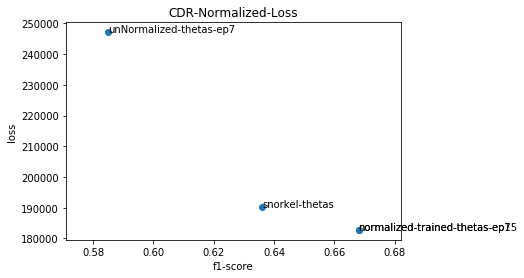

In [95]:
## Normalized loss plot loss vs f1s
    
y_loss=[190172.47,247125.96,182772.825,182772.62]
x_f1s =[0.636,0.585,0.668,0.668]
text=["snorkel-thetas","unNormalized-thetas-ep7","normalized-trained-thetas-ep7","normalized-trained-thetas-ep15"]
drawLossVsF1(y_loss,x_f1s,text,"CDR-Normalized-Loss")


In [92]:
## Objective value on snorkel thetas Unnormalized # remove logz from obj

def getUNLObjValue(th):
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.convert_to_tensor(th)

        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)
        print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) ))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
    #     train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            tl = 0
            for it in range(1):
                sess.run(train_init_op)
                
                try:
                    while True:
    #                     _,ls = sess.run([train_step,normloss])
                        ls = sess.run(normloss) # to calculate loss on fixed thetas
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"train loss",tl)

#                 sess.run(dev_init_op)
#                 a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
#                  print(a)
#                 print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
#                 print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
#                 print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
            print(a)
            print(t)
            print("dev loss",dl)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            res = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary")
            return (tl,dl,res)

print("snorkel thetas")
l_f1s = []
#snorkel thetas
l_f1s.append(getUNLObjValue(np.array([[0.2053655 , 0.30936395, 0.28997198, 0.2367527 , 0.28647343,
       0.32020677, 0.19884814, 0.30623267, 0.30723075, 0.2419398 ,
       0.25581996, 0.28299078, 0.18634078, 0.21796294, 0.20752234,
       0.19268362, 0.18442374, 0.26176987, 0.22819245, 0.18263638,
       0.30204006, 0.36018888, 0.18171976, 0.19192962, 0.30156119,
       0.22449297, 0.18345572, 0.18210333, 0.18615508, 0.18474442,
       0.19665109, 0.19592285, 0.21894825]])))

            
print("normalized thetas ep15 lr0.01")

l_f1s.append(getUNLObjValue(np.array([[ 0.28575421,  0.51761933 , 0.5207703 ,  0.36454638,  0.55417525,  0.64604823,
   0.13772734,  0.5908674,   0.64182507,  0.41374798,  0.40126751,  0.53715197,
  -0.05536051,  0.32497394,  0.21877467,  0.14599839, -0.05084094,  0.423559,
   0.32848078,  0.05423492,  0.65924925,  1.0990666 ,  0.05418686,  0.22025056,
   0.55000554,  0.33751599,  0.06750857,  0.05696271,  0.11251414, -0.01585396,
   0.11384963,  0.12932497,  0.32449617]])))


print(l_f1s)

snorkel thetas
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 33), dtype=float64)
k Tensor("Const_2:0", shape=(33,), dtype=float64)
<tf.Variable 'alphas:0' shape=(33,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 33), dtype=float64)
l Tensor("unstack:0", shape=(?, 33), dtype=float64)
nls Tensor("mul:0", shape=(?, 33), dtype=float64)
thetas Tensor("Const_1:0", shape=(1, 33), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 33), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(33,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int

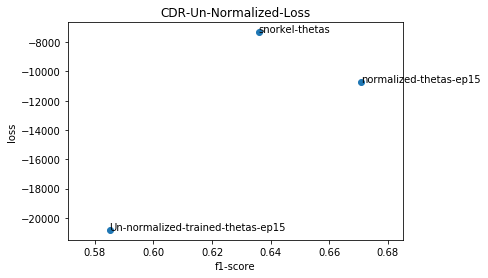

In [96]:
## UN-Normalized loss plot loss vs f1s
    
y_loss=[-7326.53,-10754.9,-20825.271]
x_f1s =[0.636,0.671,0.585]
text=["snorkel-thetas","normalized-thetas-ep15","Un-normalized-trained-thetas-ep15"]
drawLossVsF1(y_loss,x_f1s,text,"CDR-Un-Normalized-Loss")


In [88]:
## same network that didn't train
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

    thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                             dtype=tf.float64)
    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(30):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

20 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079646017699115, 0.1693121693121693, 0.09984399375975038, None)

21 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079646017699115, 0.1693121693121693, 0.09984399375975038, None)

22 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079

In [224]:
#snorkel
a =np.array([ 0.07472098,  0.07514459,  0.11910277,  0.11186369,  0.07306518,
        0.69216714,  0.07467749,  0.16012659,  0.13682546,  0.08183363])

temp = a.flatten().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(a))
print(temp)

[4 6 0 1 9 3 2 8 7 5]


In [27]:
a = np.array([-0.27082211, -0.01928787, -0.14063245,  0.37856253,  0.43681819, -0.15844807,
   0.13280198, -0.01935702, -0.10775934,  0.34390113,  0.39762823, -0.14286955,
  -0.39588527, -0.33699178, -0.37821404,  0.38378715, -0.39537146,  0.11504936,
   0.21906794,  0.39699417, -0.27113816,  8.13838832,  0.39548336, -0.31328908,
   0.25503373,  0.28019293,  0.39734506,  0.39700564,  0.37866251, -0.39156514,
   0.38002959,  0.21917987,  0.13605525])

temp = a.flatten().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(a))
print(temp)

[12 16 29 14 13 23 20  0  5 11  2  8  7  1 17  6 32 18 31 24 25  9  3 28
 30 15 22 19 27 26 10  4 21]


In [72]:
# rerun old network to get thetas
#stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(5):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                break

            if(c%4000==0):
                pl = []
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                predicted_labels = pl
                print()
                print(total_te/4000)
                total_te=0
#                 print(a)
                print(t)
#                 print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = pl
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    
train_NN()



-0.00017390038913676534
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.99962997 1.         1.         1.         1.
 1.         1.         1.00055981 0.99944019 1.         1.
 1.         1.         1.         1.         1.         0.99966171
 1.00037556 1.00038181 1.        ]
0 502
0  d  (0.6458827900831905, 0.6613175675675675, 0.6176945431062317, None)

-2.852652261056169e+32
[1.00000000e+00 4.19096332e+01 1.61282266e+01 1.00000000e+00
 1.00000000e+00 5.96595555e-01 6.53761651e-01 2.98818871e+01
 2.73636591e+01 1.00000000e+00 1.00000000e+00 1.37726648e+01
 1.00000000e+00 1.09325114e+17 1.00000000e+00 1.00000000e+00
 1.06648029e+00 9.51584748e-01 9.51436912e-01 9.84135000e-01
 5.96544835e-01 4.02272777e+10 9.60992051e-01 6.00949033e+02
 1.18230742e+02 9.52113532e-01 8.06269559e-01 8.73388071e-01
 6.56039488e-01 1.04801446e+17 8.47703035e-01 8.44365498e-01
 5.96662195e-01]
0 888
4000  d  (0.1666666666

/home/vinay/snorkelEnv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



-1.0622783407234913e+67
[1.00000000e+00 1.43344200e+03 2.48781988e+02 1.00000000e+00
 1.00000000e+00 5.96595555e-01 5.96709500e-01 7.89037703e+02
 8.81714699e+02 1.00000000e+00 1.00000000e+00 2.34544600e+02
 1.00000000e+00 2.10967076e+34 1.00000000e+00 1.00000000e+00
 1.13949202e+00 9.51575033e-01 9.51436912e-01 9.04171121e-01
 5.96544835e-01 9.36474848e+20 9.03578251e-01 3.91911816e+04
 1.12698180e+04 9.52113532e-01 6.74689330e-01 8.03451390e-01
 6.01198782e-01 2.02237656e+34 8.47703035e-01 8.42419894e-01
 5.96662195e-01]
0 888
8000  d  (0.16666666666666666, 0.5, 0.25, None)
0 -9.30043372417304e+72
0 888
(0.16666666666666666, 0.5, 0.25, None)
(0.3333333333333333, 1.0, 0.5, None)

-4.6948196355860187e+67
[1.00000000e+00 1.83829184e+03 2.94633493e+02 1.00000000e+00
 1.00000000e+00 5.96595555e-01 5.96709500e-01 1.01188714e+03
 1.06522370e+03 1.00000000e+00 1.00000000e+00 2.77785173e+02
 1.00000000e+00 3.15957251e+35 1.00000000e+00 1.00000000e+00
 1.13949202e+00 9.51575033e-01 9.51436912

/home/vinay/snorkelEnv/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars



nan
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
0 0
4000  d  (0.3333333333333333, 0.5, 0.4, None)

nan
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
0 0
8000  d  (0.3333333333333333, 0.5, 0.4, None)
4 nan
0 0
(0.3333333333333333, 0.5, 0.4, None)
(0.0, 0.0, 0.0, None)


/home/vinay/snorkelEnv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [85]:
# #stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
# import tensorflow as tf
# from tensorflow.contrib.tensorboard.plugins import projector

# def train_NN():
#     print()
#     result_dir = "./"
#     config = projector.ProjectorConfig()
#     tf.logging.set_verbosity(tf.logging.INFO)
#     summary_writer = tf.summary.FileWriter(result_dir)

#     tf.reset_default_graph()

#     dim = 2 #(labels,scores)

#     _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

#     alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
#                             dtype=tf.float64)

#     thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
#                             dtype=tf.float64)

#     l,s = tf.unstack(_x)

#     prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

#     mul_L_S = tf.multiply(l,prelu_out_s)

#     phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

#     phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

#     phi_out = tf.stack([phi_n1,phi_p1])
    
#     predict = tf.argmax(tf.nn.softmax(phi_out))

#     loss = tf.negative(tf.reduce_logsumexp(phi_out))

#     train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


#     check_op = tf.add_check_numerics_ops()

#     sess = tf.Session()
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     for i in range(1):
#         c = 0
#         te_prev=1
#         total_te = 0
#         for L_S_i in train_L_S:

#             a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
#             total_te+=te_curr

#             if(abs(te_curr-te_prev)<1e-200):
#                 break

#             if(c%4000==0):
#                 pl = []
#                 for L_S_i in dev_L_S:
#                     a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
#                     pl.append(p)
#                 predicted_labels = [-1 if x==0 else x for x in pl]
#                 print()
#                 print(total_te/4000)
#                 total_te=0
# #                 print(a)
# #                 print(t)
# #                 print()
#                 print(predicted_labels.count(-1),predicted_labels.count(1))
#                 print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
#             c+=1
#             te_prev = te_curr
#         pl = []
#         for L_S_i in dev_L_S:
#             p = sess.run(predict,feed_dict={_x:L_S_i})
#             pl.append(p)
#         predicted_labels = [-1 if x==0 else x for x in pl]
#         print(i,total_te)
#         print(predicted_labels.count(-1),predicted_labels.count(1))
#         print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
# train_NN()



-0.000226377142841
2251 545
0  d  (0.58865213829531426, 0.71341836734693875, 0.60408179957052133, None)

-1.94518369934e+28
2232 564
4000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-5.04415736866e+58
2232 564
8000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-1.33431810995e+89
2232 564
12000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-3.67295517678e+119
2232 564
16000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-9.52453175821e+149
2232 564
20000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
0 -1.71979948062e+170
2232 564
(0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
